Vítejte u domácí úlohy do SUI.
V rámci úlohy Vás čeká několik cvičení, v nichž budete doplňovat poměrně malé fragmenty kódu, místo na ně je vyznačené jako `pass` nebo `None`.
Pokud se v buňce s kódem již něco nachází, využijte/neničte to.
V dvou případech se očekává textová odpověď, tu uvedete přímo do zadávající buňky.
Buňky nerušte ani nepřidávejte.

Maximálně využívejte `numpy` a `torch` pro hromadné operace na celých polích.
S výjimkou generátoru minibatchí by se nikde neměl objevit cyklus jdoucí přes jednotlivé příklady.

U všech cvičení je uveden počet bodů za funkční implementaci a orientační počet potřebných řádků.
Berte ho prosím opravdu jako orientační, pozornost mu věnujte pouze, pokud ho významně překračujete.
Mnoho zdaru!

# Informace o vzniku řešení
Vyplňte následující údaje **(3 údaje, 0 bodů)**

* Jméno autora: Daniel Konečný
* Login autora: xkonec75
* Datum vzniku: 20. 10. 2020

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats

# Přípravné práce
Prvním úkolem v této domácí úloze je načíst data, s nimiž budete pracovat.
Vybudujte jednoduchou třídu, která se umí zkonstruovat z cesty k negativním a pozitivním příkladům, a bude poskytovat:
- pozitivní a negativní příklady (`dataset.pos`, `dataset.neg` o rozměrech [N, 7])
- všechny příklady a odpovídající třídy (`dataset.xs` o rozměru [N, 7], `dataset.targets` o rozměru [N])

K načítání dat doporučujeme využít `np.loadtxt()`.
Netrapte se se zapouzdřování a gettery, berte třídu jako Plain Old Data.

Načtěte trénovací (`{positives,negatives}.trn`), validační (`{positives,negatives}.val`) a testovací (`{positives,negatives}.tst`) dataset, pojmenujte je po řadě (`train_dataset`, `val_dataset`, `test_dataset`). 

**(6+3 řádků, 1 bod)** 


In [2]:
class Dataset:
    def __init__(self, data_type):
        self.pos = np.loadtxt(f'positives.{data_type}')
        self.neg = np.loadtxt(f'negatives.{data_type}')
        self.xs = np.vstack((self.pos, self.neg))
        self.targets = np.hstack((np.ones(len(self.pos)), np.zeros(len(self.neg))))

train_dataset = Dataset('trn')
val_dataset = Dataset('val')
test_dataset = Dataset('tst')

print('positives', train_dataset.pos.shape)
print('negatives', train_dataset.neg.shape)
print('xs', train_dataset.xs.shape)
print('targets', train_dataset.targets.shape)

positives (2280, 7)
negatives (6841, 7)
xs (9121, 7)
targets (9121,)


V řadě následujících cvičení budete pracovat s jedním konkrétním příznakem. Naimplementujte pro začátek funkci, která vykreslí histogram rozložení pozitivních a negativních příkladů (`plt.hist()`). Nezapomeňte na legendu, ať je v grafu jasné, které jsou které. Funkci zavolejte dvakrát, vykreslete histogram příznaku `5` -- tzn. šestého ze sedmi -- pro trénovací a validační data **(5 řádků, 1 bod)**.

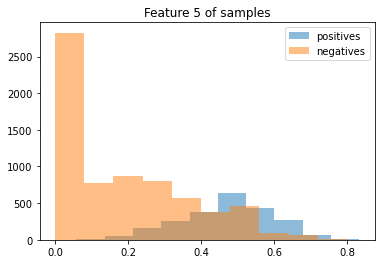

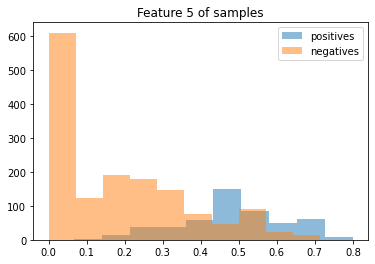

In [3]:
FOI = 5  # Feature Of Interest

def plot_data(poss, negs):
    plt.hist(poss, alpha=0.5, label='positives')
    plt.hist(negs, alpha=0.5, label='negatives')
    plt.legend()
    plt.title('Feature 5 of samples')
    plt.show()

plot_data(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI])
plot_data(val_dataset.pos[:, FOI], val_dataset.neg[:, FOI])

### Evaluace klasifikátorů
Než přistoupíte k tvorbě jednotlivých klasifikátorů, vytvořte funkci pro jejich vyhodnocování.
Nechť se jmenuje `evaluate` a přijímá po řadě klasifikátor, pole dat (o rozměrech [N] nebo [N, F]) a pole tříd ([N]).
Jejím výstupem bude _přesnost_, tzn. podíl správně klasifikovaných příkladů.

Předpokládejte, že klasifikátor poskytuje metodu `.prob_class_1(data)`, která vrací pole posteriorních pravděpodobností třídy 1 (tj. p(y=1|x)) pro daná data.
Evaluační funkce bude muset provést tvrdé prahování (na hodnotě 0.5) těchto pravděpodobností a srovnání získaných rozhodnutí s referenčními třídami.
Využijte fakt, že `numpy`ovská pole lze mj. porovnávat mezi sebou i se skalárem.

**(3 řádky, 1 bod)**

In [4]:
def evaluate(classifier, inputs, targets):
    classification = (classifier.prob_class_1(inputs) > 0.5) == (targets == 1)
    return np.count_nonzero(classification == True) / len(targets)

class Dummy:
    def prob_class_1(self, xs):
        return np.asarray([0.2, 0.7, 0.7])

print(evaluate(Dummy(), None, np.asarray([0, 0, 1])))  # should be 0.66...

0.6666666666666666


### Baseline
Vytvořte klasifikátor, který ignoruje vstupní hodnotu dat.
Jenom v konstruktoru dostane třídu, kterou má dávat jako tip pro libovolný vstup.
Nezapomeňte, že jeho metoda `.prob_class_1(data)` musí vracet pole správné velikosti, využijte `np.ones` nebo `np.full`.

**(4 řádky, 1 bod)**

In [5]:
class PriorClassifier:
    def __init__(self, default_class):
        self.default_class = default_class

    def prob_class_1(self, xs):
        return np.full(xs.shape, self.default_class)

baseline = PriorClassifier(0)
val_acc = evaluate(baseline, val_dataset.xs[:, FOI], val_dataset.targets)
print('Baseline val acc:', val_acc)

Baseline val acc: 0.75


# Generativní klasifikátory
V této  části vytvoříte dva generativní klasifikátory, oba založené na Gaussovu rozložení pravděpodobnosti.

Začněte implementací funce, která pro daná 1-D data vrátí Maximum Likelihood odhad střední hodnoty a směrodatné odchylky Gaussova rozložení, které data modeluje.
Funkci využijte pro natrénovaní dvou modelů: pozitivních a negativních příkladů.
Získané parametry -- tzn. střední hodnoty a směrodatné odchylky -- vypište.

**(5 řádků, 0.5 bodu)**

In [6]:
def get_gauss_params(data):
    return np.mean(data), np.std(data)

pos_mean, pos_std = get_gauss_params(train_dataset.pos[:, FOI])
neg_mean, neg_std = get_gauss_params(train_dataset.neg[:, FOI])
print(f'Positive train samples:\n- mean = {pos_mean:.05f}\n- std = {pos_std:.05f}')
print(f'Negative train samples:\n- mean = {neg_mean:.05f}\n- std = {neg_std:.05f}')

Positive train samples:
- mean = 0.47843
- std = 0.12972
Negative train samples:
- mean = 0.17454
- std = 0.17896


Ze získaných parametrů vytvořte `scipy`ovská gaussovská rozložení `scipy.stats.norm`.
S využitím jejich metody `.pdf()` vytvořte graf, v němž srovnáte skutečné a modelové rozložení pozitivních a negativních příkladů.
Rozsah x-ové osy volte od -0.5 do 1.5 (využijte `np.linspace`) a u volání `plt.hist()` nezapomeňte nastavit `density=True`, aby byl histogram normalizovaný a dal se srovnávat s modelem.

**(2+8 řádků, 1 bod)**

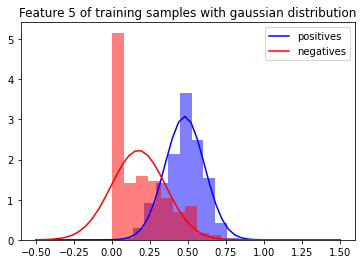

In [7]:
gauss_pos = scipy.stats.norm(pos_mean, pos_std)
gauss_neg = scipy.stats.norm(neg_mean, neg_std)

axis_range = np.linspace(-0.5, 1.5)
plt.plot(axis_range, gauss_pos.pdf(axis_range), color='blue', label='positives')
plt.plot(axis_range, gauss_neg.pdf(axis_range), color='red', label='negatives')
plt.hist(train_dataset.pos[:, FOI], density=True, alpha=0.5, color='blue')
plt.hist(train_dataset.neg[:, FOI], density=True, alpha=0.5, color='red')
plt.legend()
plt.title('Feature 5 of training samples with gaussian distribution')
plt.show()

Naimplementujte binární generativní klasifikátor. 
Při konstrukci přijímá dvě rozložení poskytující metodu `.pdf()` a odpovídající apriorní pravděpodobnost tříd.
Jako všechny klasifikátory v této domácí úloze poskytuje metodu `prob_class_1()`.

**(9 řádků, 2 body)**

In [8]:
class BinaryClassifier:
    def __init__(self, classifier0, classifier1, prior):
        self.classifier0 = classifier0
        self.classifier1 = classifier1
        self.p_0 = prior

    def prob_class_1(self, xs):
        p_0 = self.p_0                      # Prior probability of class 0
        p_1 = 1 - self.p_0                  # Prior probability of class 1
        p_x_0 = self.classifier0.pdf(xs)    # Probability of sample coming from class 0
        p_x_1 = self.classifier1.pdf(xs)    # Probability of sample coming from class 1
        p_x = (p_x_0 * p_0) + (p_x_1 * p_1) # Probability of sample
        p_1_x = (p_x_1 * p_1) / p_x         # Probability of class 1 given a sample (Bayes rule)
        return p_1_x

Nainstancujte dva generativní klasifikátory: jeden s rovnoměrnými priory a jeden s apriorní pravděpodobností 0.75 pro třídu 0 (negativní příklady).
Pomocí funkce `evaluate()` vyhodnoťte jejich úspěšnost na validačních datech.

**(2 řádky, 1 bod)**

In [9]:
classifier_flat_prior = BinaryClassifier(gauss_neg, gauss_pos, 0.5)
classifier_full_prior = BinaryClassifier(gauss_neg, gauss_pos, 0.75)

print('flat:', evaluate(classifier_flat_prior, val_dataset.xs[:, FOI], val_dataset.targets))
print('full:', evaluate(classifier_full_prior, val_dataset.xs[:, FOI], val_dataset.targets))

flat: 0.809
full: 0.8475


Vykreslete průběh posteriorní pravděpodobnosti třídy 1 jako funkci příznaku 5 pro oba klasifikátory, opět v rozsahu <-0.5; 1.5>.
Do grafu zakreslete i histogramy rozložení trénovacích dat, opět s `density=True` pro zachování dynamického rozsahu.

**(8 řádků, 1 bod)**

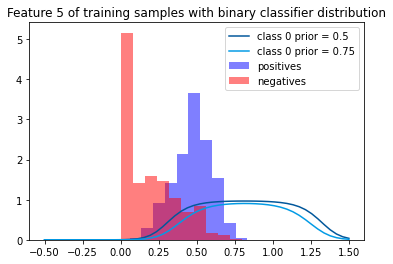

In [10]:
axis_range = np.linspace(-0.5, 1.5)
plt.plot(axis_range, classifier_flat_prior.prob_class_1(axis_range),
         color='#01579B', label='class 0 prior = 0.5')
plt.plot(axis_range, classifier_full_prior.prob_class_1(axis_range),
         color='#039BE5', label='class 0 prior = 0.75')
plt.hist(train_dataset.pos[:, FOI], density=True, alpha=0.5, color='blue', label='positives')
plt.hist(train_dataset.neg[:, FOI], density=True, alpha=0.5, color='red', label='negatives')
plt.legend()
plt.title('Feature 5 of training samples with binary classifier distribution')
plt.show()

Interpretujte, přímo v této textové buňce, každou rozhodovací hranici, která je v grafu patrná **(3 věty, 2 body)**:
* První možná rozhodovací hranice je tvořena překryvem mezi histogramy, přesněji místem, kde začnou převažovat pozitivní vzorky nad negativními.
* Další rozhodovací hranicí jsou modré křivky tvořené binárními klasifikátory. pokud hodnota jejich funkce přesáhne 0.5, je vzorek klasifikovaný jako patřící do dané třídy. Zvyšováním váhy třídy 0 (počtu vzorků) se rozhodovací hranice stává "přísnější" pro data klasifikovaná jako pozitivní vzorky -- musí být jednoznačněji rozpoznatelné.

# Diskriminativní klasifikátory
V následující části budete přímo modelovat posteriorní pravděpodobnost třídy 1.
Modely budou založeny na PyTorchi, ten si prosím nainstalujte.
GPU rozhodně nepotřebujete, veškeré výpočty budou velmi rychlé, ne-li bleskové.

Do začátku máte poskytnutou třídu klasifikátoru z jednoho příznaku.

In [11]:
import torch
import torch.nn.functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.parameter.Parameter(torch.tensor([1.0]))
        self.b = torch.nn.parameter.Parameter(torch.tensor([0.0]))
        
    def forward(self, x):
        return torch.sigmoid(self.w*x + self.b)
    
    def prob_class_1(self, x):
        prob = self(torch.from_numpy(x))
        return prob.detach().numpy()

Pro trénovaní diskriminativních modelů budete potřebovat minibatche.
Implementujte funkci, která je bude z daných vstupních a cílových hodnot vytvářet.
Výsledkem musí být možno iterovat, ideálně funkci napište jako generátor (využijte klíčové slovo `yield`).
Jednotlivé prvky výstupu budou dvojice PyTorchových `FloatTensor`ů (musíte zkonvertovat z numpy a nastavit typ) -- první prvek vstupní data, druhý očekávané výstupy.
Počítejte s tím, že vstup bude `numpy`ovské pole, rozumná implementace využije `np.random.permutation()` a [Advanced Indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Připravený kód funkci použije na konstrukci tří minibatchí pro trénování identity, měli byste vidět celkem pět prvků náhodně uspořádaných do dvojic, ovšem s tím, že s sebou budou mít odpovídající výstupy.

**(6 řádků, 2 body)**

In [47]:
def batch_provider(xs, targets, batch_size=10):
    shuffle = np.random.permutation(targets.size)
    for i in range(0, len(shuffle), batch_size):
        batch_indices = shuffle[i:i+batch_size]
        yield torch.from_numpy(xs[batch_indices]).float(), \
              torch.from_numpy(targets[batch_indices]).float()

inputs = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
targets = np.asarray([1.0, 2.0, 3.0, 4.0, 5.0])
for x, t in batch_provider(inputs, targets, 2):
    print(f'x: {x}, t: {t}')

x: tensor([3., 5.]), t: tensor([3., 5.])
x: tensor([2., 1.]), t: tensor([2., 1.])
x: tensor([4.]), t: tensor([4.])


Dalším krokem je implementovat funkci, která model vytvoří a natrénuje.
Jejím výstupem bude (1) natrénovaný model, (2) průběh trénovací loss a (3) průběh validační přesnosti.
Jako model vracejte ten, který dosáhne nejlepší validační přesnosti.
Jako loss použijte binární cross-entropii (`F.binary_cross_entropy()`), akumulujte ji přes minibatche a logujte průměr.
Pro výpočet validační přesnosti využijte funkci `evaluate()`.
Oba průběhy vracejte jako obyčejné seznamy.

V implementaci budete potřebovat dvě zanořené smyčky: jednu pro epochy (průchody přes celý dataset) a uvnitř druhou, která bude iterovat přes jednotlivé minibatche.
Na konci každé epochy vyhodnoťte model na validačních datech.
K datasetům (trénovacímu a validačnímu) přistupujte bezostyšně jako ke globálním proměnným.

**(cca 14 řádků, 3 body)**

In [93]:
def train_single_fea_llr(fea_no, nb_epochs, lr, batch_size):
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    model = LogisticRegression()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
       
    for epoch_index in range(nb_epochs):
        accumulated_loss, batch_index_counter = 0, 0
        for batch_x, batch_target in batch_provider(train_dataset.xs[:, fea_no],
                                                     train_dataset.targets,
                                                     batch_size):
            optimizer.zero_grad()
            output = model(batch_x)
            last_loss = F.binary_cross_entropy(output, batch_target)
            last_loss.backward()
            optimizer.step()
            accumulated_loss += last_loss
            batch_index_counter += 1
        last_accuracy = evaluate(model, val_dataset.xs[:, fea_no], val_dataset.targets)
        print(f'Epoch {epoch_index} - accuracy: {last_accuracy}')
        if all(accuracy < last_accuracy for accuracy in accuracies):
            best_model = model
        accuracies.append(last_accuracy)
        losses.append(accumulated_loss/batch_index_counter)

    return best_model, losses, accuracies

Funkci zavolejte a natrénujte model.
Uveďte zde parametry, které vám dají slušný výsledek.
Měli byste dostat přesnost srovnatelnou s generativním klasifikátorem s nastavenými priory.
Neměli byste potřebovat víc než 100 epoch.
Vykreslete průběh trénovací loss a validační přesnosti, osu x značte v epochách.

V druhém grafu vykreslete histogramy trénovacích dat a pravděpodobnost třídy 1 pro x od -0.5 do 1.5, podobně jako výše u generativních klasifikátorů.
Při výpočtu výstupů využijte `with torch.no_grad():`.
**(1 + 6 + 9 řádků, 1 bod)**

Epoch 0 - accuracy: 0.536
Epoch 1 - accuracy: 0.536
Epoch 2 - accuracy: 0.536
Epoch 3 - accuracy: 0.5375
Epoch 4 - accuracy: 0.5435
Epoch 5 - accuracy: 0.5525
Epoch 6 - accuracy: 0.5575
Epoch 7 - accuracy: 0.5625
Epoch 8 - accuracy: 0.572
Epoch 9 - accuracy: 0.5835
Epoch 10 - accuracy: 0.5965
Epoch 11 - accuracy: 0.6095
Epoch 12 - accuracy: 0.616
Epoch 13 - accuracy: 0.6315
Epoch 14 - accuracy: 0.644
Epoch 15 - accuracy: 0.659
Epoch 16 - accuracy: 0.667
Epoch 17 - accuracy: 0.681
Epoch 18 - accuracy: 0.683
Epoch 19 - accuracy: 0.7035
Epoch 20 - accuracy: 0.7085
Epoch 21 - accuracy: 0.7185
Epoch 22 - accuracy: 0.727
Epoch 23 - accuracy: 0.735
Epoch 24 - accuracy: 0.763
Epoch 25 - accuracy: 0.7645
Epoch 26 - accuracy: 0.774
Epoch 27 - accuracy: 0.776
Epoch 28 - accuracy: 0.7905
Epoch 29 - accuracy: 0.8
Epoch 30 - accuracy: 0.804
Epoch 31 - accuracy: 0.8075
Epoch 32 - accuracy: 0.809
Epoch 33 - accuracy: 0.83
Epoch 34 - accuracy: 0.8305
Epoch 35 - accuracy: 0.831
Epoch 36 - accuracy: 0.83

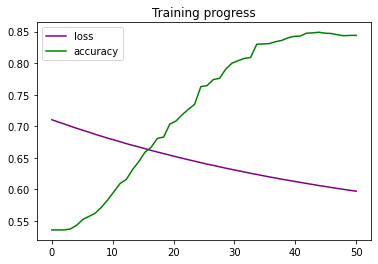

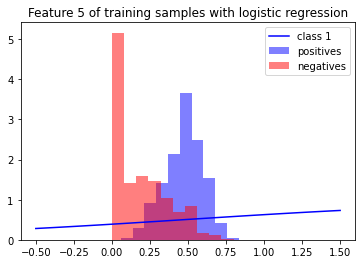

In [100]:
best_model, losses, accuracies = train_single_fea_llr(FOI, 50, 1e-3, 256)

axis_range = np.linspace(0, 50)
plt.plot(axis_range, losses, color='purple', label='loss')
plt.plot(axis_range, accuracies, color='green', label='accuracy')
plt.legend()
plt.title('Training progress')
plt.show()

axis_range = np.linspace(-0.5, 1.5)
best_model.eval()
with torch.no_grad():
    output = best_model(axis_range)
plt.plot(axis_range, output, color='blue', label='class 1')
plt.hist(train_dataset.pos[:, FOI], density=True, alpha=0.5, color='blue', label='positives')
plt.hist(train_dataset.neg[:, FOI], density=True, alpha=0.5, color='red', label='negatives')
plt.legend()
plt.title('Feature 5 of training samples with logistic regression')
plt.show()

## Všechny vstupní příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všech sedm vstupních příznaků.

Prvním krokem je naimplementovat příslusný model.
Bezostyšně zkopírujte tělo třídy `LogisticRegresion` a upravte ji tak, aby zvládala libovolný počet vstupů, využijte `torch.nn.Linear`.
U výstupu metody `.forward()` dejte pozor, aby měl výstup tvar `[N]`; pravděpodobně budete potřebovat `squeeze`.

**(9 řádků, 1 bod)**

In [ ]:
pass

Podobně jako u jednodimenzionálni regrese implementujte funkci pro trénovaní plné logistické regrese.
V ideálním případě vyfaktorujete společnou implementaci, které budete pouze předávat různá trénovací a validační data.

Zvídaví mohou zkusit `Adam`a jako optimalizátor namísto obyčejného `SGD`.

Funkci zavolejte, natrénujte model.
Opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se s přesností dostat nad 90 %.

**(ne víc než cca 30 řádků při kopírování, 1 bod)**

In [ ]:
pass

# Závěrem
Konečně vyhodnoťte všech pět vytvořených klasifikátorů na testovacích datech. Stačí doplnit jejich názvy a předat jim příznaky, na které jsou zvyklé.

**(0.5 bodu)**

In [ ]:
xs_full = test_dataset.xs
xs_foi = test_dataset.xs[:, FOI]
targets = test_dataset.targets

print('Baseline:', evaluate(None, None, targets))
print('Generative classifier (w/o prior):', evaluate(None, None, targets))
print('Generative classifier (correct):', evaluate(None, None, targets))
print('Logistic regression:', evaluate(None, None, targets))
print('logistic regression all features:', evaluate(None, None, targets))

Blahopřejeme ke zvládnutí domácí úlohy! Notebook spusťte načisto (Kernel -> Restart & Run all), vyexportuje jako PDF a odevzdejte pojmenovaný svým loginem.

Mimochodem, vstupní data nejsou synteticky generovaná. Nasbírali jsme je z projektu; Vaše klasifikátory v této domácí úloze predikují, že daný hráč vyhraje; takže by se daly použít jako heuristika pro ohodnocování listových uzlů ve stavovém prostoru hry.
Pro představu, odhadujete to z pozic pět kol před koncem partie pro daného hráče.
Poskytnuté příznaky popisují globální charakteristiky stavu hry jako je například poměr délky hranic předmětného hráče k ostatním hranicím.